In [2]:
import pickle
import time
from functools import reduce
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from panelsplit.application import cross_val_fit_predict
from panelsplit.cross_validation import PanelSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
  accuracy_score,
  classification_report,
  confusion_matrix,
  f1_score,
  precision_score,
  recall_score,
  roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_colwidth', None)

In [2]:
class TargetEngineer():

  """
  Class to generate target variables for incidence and onset under a given horizon.

  Args
  ----

  df: pd.DataFrame
    Dataframe with at least columns that include [unit, time, y_col]

  unit: str
    Column that defines your unit. E.g. 'isocode'

  time: str
    Column that defines your time. E.g. 'period'

  y_col: str
    Column that defines your y variable. E.g. 'violence'
  """

  def __init__(self, df:pd.DataFrame, unit:str, time:str, y_col:str):

    self.df = df.copy()
    self.unit = unit
    self.time = time
    self.y_col = y_col

  def any(self, threshold:int):

    """
    Function to compute "any" variable.

    Args
    ----

    threshold: int
      Threshold to apply to self.y_col.

    Returns
    -------

    pd.DataFrame
      Dataframe with any variable.

    str
      Name of the any variable.
    """

    any_col = f"any{self.y_col}_th{threshold}"
    self.df[any_col] = (self.df[self.y_col] > threshold).astype(int)
    return self.df.copy(), any_col

  def incidence(self, threshold:int, horizon:int):

    """
    Function to compute incidence target variable based on the specific threshold and horizon.

    Args
    ----

    threshold: int
      Threshold to apply to self.y_col.

    horizon: int
      Forecasting horizon (assumes aggregated window).

    Returns
    -------

    pd.DataFrame
      Dataframe with y_col, any_col, and target_col.
    """

    #make the any variable
    df, any_col = self.any(threshold)

    #get the rolling max value of your any variable over the specified horizon
    any_col_max = f"{any_col}_max"
    df[any_col_max] = self.df.groupby(self.unit)[any_col]. \
            transform(lambda x: x.rolling(window=horizon, min_periods = horizon).max())

    #shift any_col_max by the specified horizon to get your incidence target variable
    target_col = f"inc_{any_col}_h{horizon}"
    df[target_col] = df.groupby(self.unit)[any_col_max].transform(lambda x: x.shift(-horizon))

    return df[[self.y_col, any_col, target_col]]

  def onset(self, threshold:int, horizon:int):

    """
    Function to compute onset target variable based on the specific threshold and horizon.

    Args
    ----

    threshold: int
      Threshold to apply to self.y_col.

    horizon: int
      Forecasting horizon (assumes aggregated window).

    Returns
    -------

    pd.DataFrame
      Dataframe with y_col, any_col, and target_col.
    """

    #make the any variable
    df, any_col = self.any(threshold)

    def _onset(x:pd.Series, h:int):

      """
      Function to compute onset target variable for a single unit

      Args
      ---

      x: pd.Series
        The "any" variable for a single unit.

      h: int
        Forecasting horizon (assumes aggregated window).

      Returns
      -------

      pd.Series
        The onset target variable for a single unit.
      """

      index = x.index #get the index
      x = list(x) #convert to list
      y = [] #empty list for storing the onset target
      for i in range(len(x)): #iterate over every element in x
          i0 = i+1 #index of the next period
          i1 = i0+h #index at the end of the forecast horizon
          if i1 <= len(x) and x[i]==0: #first if condition is to handle the last h observations. Second condition states if any==0.
              y.append(np.max(x[i0:i1])) #append the max of the any column in the next h periods, assuming any==0 currently
          else:
              y.append(np.nan) #otherwise append NA
      return pd.Series(y, index)

    target_col = f"ons_{any_col}_h{horizon}"
    df[target_col] = self.df.groupby(self.unit)[any_col].transform(lambda x: _onset(x, horizon))

    return df[[self.y_col, any_col, target_col]]

In [3]:
class FeatureEngineer:

    """
    This is a class that contains general methods that can be applied to a DataFrame to create new features. Examples of such methods include creating lagged variables, rolling min/mean/max/sum and weighted rolling mean/sum.
    The methods in this class are designed to be used in a pipeline to create new features for a given DataFrame.

    Attributes:
    -----------
    groupby_cols : Union[str, list]
        A str or list of columns to group by

    Methods:
    --------

    lag(input_df:pd.DataFrame, y_col:str, lags:list):
        This is a method that creates lagged variables for a given column in a DataFrame.

    rolling_sum(input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):
        This is a method that creates the rolling sum of specified windows for a given column in a DataFrame.

    rolling_mean(input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):
        This is a method that creates the rolling mean of specified windows for a given column in a DataFrame.

    rolling_min(input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):
        This is a method that creates the rolling min of specified windows for a given column in a DataFrame.

    rolling_max(input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):
        This is a method that creates the rolling max of specified windows for a given column in a DataFrame.

    rolling_std(input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):
        This is a method that creates the rolling standard deviation of specified windows for a given column in a DataFrame.

    create_exponential_weights(window_size, alpha=0.8):
        This is a method that enables generating "rolling" exponential weights for a given window size.

    weighted_rolling_sum(input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False, alpha = 0.8):
        This is a method that creates the weighted rolling sum of specified windows for a given column in a DataFrame.

    weighted_rolling_mean(input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False, alpha = 0.8):
        This is a method that creates the weighted rolling mean of specified windows for a given column in a DataFrame.

    count_since(input_df:pd.DataFrame, y_col:str, thresholds:list, shift_knowledge:int = None):
        This is a method that counts the number of periods since a variable has been above a given threshold.

    ongoing(input_df:pd.DataFrame, y_col:str, thresholds:list, shift_knowledge:int = None):
        This is a method that represents a sequential count of the number of periods for which a variable has been above a given threshold.

    Notes:
    -------
    Be very careful with NAs when using the count_since_thresh and ongoing_episode methods.
    The way we are computing things here (i.e. using a > th condition) means they are treated as a 0/False.
    """

    def __init__(self, groupby_cols: Union[str, list]):

        self.groupby_cols = groupby_cols

    def _index_check(self, df:pd.DataFrame):

        """
        This is a method that checks if the index of a DataFrame is sorted correctly.

        Args:
        -----
        :param df: The DataFrame to check.

        Returns:
        --------
        :return: The DataFrame with a sorted index.
        """

        assert df.index.is_monotonic_increasing, "The index of the DataFrame should be monotonically increasing."

    def lag(self, input_df:pd.DataFrame, y_col:str, lags:list):

        """
        This is a method that creates lagged variables for a given column in a DataFrame.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create lagged variables.
        :param lags: A list of lag values to create.

        Returns:
        --------
        :return: The original DataFrame with the lagged variables appended.
        """
        df = input_df.copy()

        self._index_check(df)

        col_names = [y_col + '_basic_lag' + str(lag) for lag in lags]
        for idx, lag in enumerate(lags):
            df[col_names[idx]] = df.groupby(self.groupby_cols)[y_col].shift(lag)
        return df

    def rolling_sum(self, input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):

        """
        This is a method that creates the rolling sum of specified windows for a given column in a DataFrame.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create lagged variables.
        :param groupby_cols: A list of columns to group by.
        :param windows: A list of windows to generate a rolling sum for.
        :param closed: A string indicating the side of the window interval to close on. Closed = 'left' omits the current observation.
        :param return_logs: A boolean indicating whether to return the log of the rolling sum.

        Returns:
        --------
        :return: The original DataFrame with the rolling sum variables appended.

        """

        df = input_df.copy()

        self._index_check(df)

        col_names = [y_col + '_rolling_sum' + str(w) for w in windows]

        for idx, w in enumerate(windows):
            df[col_names[idx]] = df.groupby(self.groupby_cols)[y_col].rolling(w, min_periods=1, closed = closed).sum().values
            if return_logs:
                df['ln_' + col_names[idx]] = np.log1p(df[col_names[idx]])
                df = df.drop(col_names[idx], axis = 1)
        return df

    def rolling_mean(self, input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):

        """
        This is a method that creates the rolling mean of specified windows for a given column in a DataFrame.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create rolling variables.
        :param windows: A list of windows to generate a rolling mean for.
        :param closed: A string indicating the side of the window interval to close on. Closed = 'left' omits the current observation.
        :param return_logs: A boolean indicating whether to return the log of the rolling mean.

        Returns:
        --------
        :return: The original DataFrame with the rolling mean variables appended.

        """

        df = input_df.copy()

        self._index_check(df)

        col_names = [y_col + '_rolling_mean' + str(w) for w in windows]

        for idx, w in enumerate(windows):
            df[col_names[idx]] = df.groupby(self.groupby_cols)[y_col].rolling(w, min_periods=1, closed = closed).mean().values
            if return_logs:
                df['ln_' + col_names[idx]] = np.log1p(df[col_names[idx]])
                df = df.drop(col_names[idx], axis = 1)
        return df

    def rolling_min(self, input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):

        """
        This is a method that creates the rolling min of specified windows for a given column in a DataFrame.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create rolling variables.
        :param windows: A list of windows to generate a rolling min for.
        :param closed: A string indicating the side of the window interval to close on. Closed = 'left' omits the current observation.
        :param return_logs: A boolean indicating whether to return the log of the rolling min.

        Returns:
        --------
        :return: The original DataFrame with the rolling min variables appended.

        """

        df = input_df.copy()

        self._index_check(df)

        col_names = [y_col + '_rolling_min' + str(w) for w in windows]

        for idx, w in enumerate(windows):
            df[col_names[idx]] = df.groupby(self.groupby_cols)[y_col].rolling(w, min_periods=1, closed = closed).min().values
            if return_logs:
                df['ln_' + col_names[idx]] = np.log1p(df[col_names[idx]])
                df = df.drop(col_names[idx], axis = 1)
        return df

    def rolling_max(self, input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):

        """
        This is a method that creates the rolling max of specified windows for a given column in a DataFrame.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create rolling variables.
        :param windows: A list of windows to generate a rolling max for.
        :param closed: A string indicating the side of the window interval to close on. Closed = 'left' omits the current observation.
        :param return_logs: A boolean indicating whether to return the log of the rolling max.

        Returns:
        --------
        :return: The original DataFrame with the rolling max variables appended.

        """

        df = input_df.copy()

        self._index_check(df)

        col_names = [y_col + '_rolling_max' + str(w) for w in windows]

        for idx, w in enumerate(windows):
            df[col_names[idx]] = df.groupby(self.groupby_cols)[y_col].rolling(w, min_periods=1, closed = closed).max().values
            if return_logs:
                df['ln_' + col_names[idx]] = np.log1p(df[col_names[idx]])
                df = df.drop(col_names[idx], axis = 1)
        return df

    def rolling_std(self, input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False):

        """
        This is a method that creates the rolling standard deviation of specified windows for a given column in a DataFrame.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create rolling variables.
        :param windows: A list of windows to generate a rolling standard deviation for.
        :param closed: A string indicating the side of the window interval to close on. Closed = 'left' omits the current observation.
        :param return_logs: A boolean indicating whether to return the log of the rolling standard deviation.

        Returns:
        --------
        :return: The original DataFrame with the rolling standard deviation variables appended.

        """

        df = input_df.copy()

        self._index_check(df)

        col_names = [y_col + '_rolling_std' + str(w) for w in windows]

        for idx, w in enumerate(windows):
            df[col_names[idx]] = df.groupby(self.groupby_cols)[y_col].rolling(w, min_periods=1, closed = closed).std().values
            if return_logs:
                df['ln_' + col_names[idx]] = np.log1p(df[col_names[idx]])
                df = df.drop(col_names[idx], axis = 1)
        return df

    def _create_exponential_weights(self, window_size, alpha=0.8):

        """
        This is a method that enables generating "rolling" exponential weights for a given window size.

        Args:
        -----
        :param window_size: The size of the window for which weights are calculated.
        :param alpha: The decay factor for weights, defaults to 0.5.
                    A higher alpha discounts older observations faster.

        Returns:
        -----
        :return: A numpy array of weights.
        """

        weights = alpha ** np.arange(window_size)
        normalized_weights = weights / weights.sum()
        return normalized_weights[::-1]

    def weighted_rolling_sum(self, input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False, alpha = 0.8):

        """
        This is a method that creates the weighted rolling sum of specified windows for a given column in a DataFrame.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create weighted rolling variables.
        :param groupby_cols: A list of columns to group by.
        :param windows: A list of windows to generate a weighted rolling sum for.
        :param closed: A string indicating the side of the window interval to close on. Closed = 'left' omits the current observation.
        :param return_logs:  A boolean indicating whether to return the log of the weighted rolling sum.
        :param alpha: The decay factor for weights, defaults to 0.8. A higher alpha discounts older observations faster.

        Returns:
        -----
        :return: The original DataFrame with the weighted rolling sum variables appended.
        """

        df = input_df.copy()

        self._index_check(df)

        col_names = [y_col + '_weighted_rolling_sum' + str(w) for w in windows]

        for idx, w in enumerate(windows):
            df[col_names[idx]] = df.groupby(self.groupby_cols)[y_col].rolling(w, min_periods=1, closed = closed).apply(lambda x: np.sum(self._create_exponential_weights(len(x), alpha) * x), raw = True).values
            if return_logs:
                df['ln_' + col_names[idx]] = np.log1p(df[col_names[idx]])
                df = df.drop(col_names[idx], axis = 1)
        return df

    def weighted_rolling_mean(self, input_df:pd.DataFrame, y_col:str, windows:list, closed = None, return_logs = False, alpha = 0.8):
        """
        This is a method that creates the weighted rolling mean of specified windows for a given column in a DataFrame.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create weighted rolling variables.
        :param windows: A list of windows to generate a weighted rolling mean for.
        :param closed: A string indicating the side of the window interval to close on. Closed = 'left' omits the current observation.
        :param return_logs:  A boolean indicating whether to return the log of the weighted rolling mean.
        :param alpha: The decay factor for weights, defaults to 0.8. A higher alpha discounts older observations faster.

        Returns:
        --------
        :return: The original DataFrame with the weighted rolling mean variables appended.
        """

        df = input_df.copy()

        self._index_check(df)

        col_names = [y_col + '_weighted_rolling_mean' + str(w) for w in windows]

        for idx, w in enumerate(windows):
            df[col_names[idx]] = df.groupby(self.groupby_cols)[y_col].rolling(w, min_periods=1, closed = closed).apply(lambda x: np.sum(self._create_exponential_weights(len(x), alpha) * x) / len(x), raw = True).values
            if return_logs:
                df['ln_' + col_names[idx]] = np.log1p(df[col_names[idx]])
                df = df.drop(col_names[idx], axis = 1)
        return df

    def _count_since(self, x: pd.Series):
        """
        This is a method that counts the number of periods since a variable has been 1.

        :param x: A pandas Series containing the target variable.

        Returns:
        - y (list): A list containing the number of periods since the target variable has been 1.
        """

        x = list(x)
        y = []
        for n in range(0, len(x)):
            if (x[n] == 0) & (n == 0):
                y.append(1) # if it starts with no flows
            elif x[n] == 1:
                y.append(0) # reset to 0 if flows
            else:
                y.append(y[n-1]+1) # add 1 if no flows
        return y

    def since(self, input_df:pd.DataFrame, y_col:str, thresholds:list, shift_knowledge:int = None):

        """
        This is a method that counts the number of periods since a variable has been above a given threshold.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create the count since variable.
        :param thresholds: A list of thresholds to count since.
        :param shift_knowledge: An integer defining by how many periods to shift the count since variable.

        Returns:
        --------
        :return: The original DataFrame with the count since variables appended.
        """

        df = input_df.copy()

        self._index_check(df)


        binary_col_names = [y_col + '_above' + str(th) for th in thresholds]
        col_names = [y_col + '_since_' + str(th) for th in thresholds]

        for idx, th in enumerate(thresholds):
            df[binary_col_names[idx]] = (df[y_col] > th).astype(int)
            df[col_names[idx]] = df.groupby(self.groupby_cols)[binary_col_names[idx]].transform(self._count_since)

            if shift_knowledge is None:
                pass
            else:
                #in case we need to shift by one since we don't know the y_col in current period
                df[binary_col_names[idx]] = df.groupby(self.groupby_cols)[[binary_col_names[idx]]].shift(shift_knowledge)
                df[col_names[idx]] = df.groupby(self.groupby_cols)[col_names[idx]].shift(shift_knowledge)
        return df[[y_col, *[x for x in df.columns if 'since' in x]]]

    def _count_ongoing(self, x: pd.Series):
        """
        This is a method that generates a sequential count of the periods for which a variable has been 1.

        :param x: A pandas Series containing the target variable.

        Returns:
        - y (list): A list containing the sequential count of the periods for which the target variable has been 1.
        """

        x = list(x)
        y = []
        episode_counter = 0
        for n in range(0, len(x)):
            if (x[n] == 0) & (n == 0):
                y.append(episode_counter) # if it starts with no flows
            elif x[n] == 1:
                episode_counter += 1
                y.append(episode_counter) # if there are flows
            else:
                y.append(0) # reset to 0 if no flows
                episode_counter = 0
        return y

    def ongoing(self, input_df:pd.DataFrame, y_col:str, thresholds:list, shift_knowledge:int = None):

        """
        This is a method that represents a sequential count of the number of periods for which a variable has been above a given threshold.

        Args:
        -----
        :param input_df: The DataFrame containing the data.
        :param y_col: The name of the column for which to create the count since variable.
        :param thresholds: A list of thresholds to count since.
        :param shift_knowledge: An integer defining by how many periods to shift the count since variable.

        Returns:
        --------
        :return: The original DataFrame with the count since variables appended.
        """

        df = input_df.copy()

        self._index_check(df)

        binary_col_names = [y_col + '_above' + str(th) for th in thresholds]
        col_names = [y_col + '_ongoing_' + str(th) for th in thresholds]

        for idx, th in enumerate(thresholds):
            df[binary_col_names[idx]] = (df[y_col] > th).astype(int)
            df[col_names[idx]] = df.groupby(self.groupby_cols)[binary_col_names[idx]].transform(self._count_ongoing)

            if shift_knowledge is None:
                pass
            else:
                #in case we need to shift by one since we don't know the y_col in current period
                df[binary_col_names[idx]] = df.groupby(self.groupby_cols)[[binary_col_names[idx]]].shift(shift_knowledge)
                df[col_names[idx]] = df.groupby(self.groupby_cols)[col_names[idx]].shift(shift_knowledge)
        return df[[y_col, *[x for x in df.columns if 'ongoing' in x]]]


# Data preparation

## Making the panel df of terrorism incidence

In [ ]:
# Load the Global Terrorism Dataset
attacks1 = pd.read_excel('terrorismdb_2020.xlsx')
attacks2 = pd.read_excel('terrorismdb_2021.xlsx')

In [ ]:
# Filter attacks1 for year 2020 and country code 217
attacks1_filtered = attacks1[attacks1['iyear'] == 2020]
attacks1_filtered = attacks1_filtered[attacks1_filtered['country'] == 217]
attacks2_filtered = attacks2[attacks2['country'] == 217]

# Concatenate the filtered datasets
attacks = pd.concat([attacks1_filtered, attacks2_filtered], ignore_index=True)
attacks = attacks[['iyear', 'imonth', 'country', 'provstate', 'targtype1_txt']].copy()

# Clean up to free memory
del attacks1, attacks2, attacks1_filtered, attacks2_filtered

# Create a mapping of state names to ADM1 codes
state_to_code = {
    'Alabama': 'USAL',
    'Alaska': 'USAK',
    'Arizona': 'USAZ',
    'Arkansas': 'USAR',
    'California': 'USCA',
    'Colorado': 'USCO',
    'Connecticut': 'USCT',
    'Delaware': 'USDE',
    'District of Columbia': 'USDC',
    'Florida': 'USFL',
    'Georgia': 'USGA',
    'Hawaii': 'USHI',
    'Idaho': 'USID',
    'Illinois': 'USIL',
    'Indiana': 'USIN',
    'Iowa': 'USIA',
    'Kansas': 'USKS',
    'Kentucky': 'USKY',
    'Louisiana': 'USLA',
    'Maine': 'USME',
    'Maryland': 'USMD',
    'Massachusetts': 'USMA',
    'Michigan': 'USMI',
    'Minnesota': 'USMN',
    'Mississippi': 'USMS',
    'Missouri': 'USMO',
    'Montana': 'USMT',
    'Nebraska': 'USNE',
    'Nevada': 'USNV',
    'New Hampshire': 'USNH',
    'New Jersey': 'USNJ',
    'New Mexico': 'USNM',
    'New York': 'USNY',
    'North Carolina': 'USNC',
    'North Dakota': 'USND',
    'Ohio': 'USOH',
    'Oklahoma': 'USOK',
    'Oregon': 'USOR',
    'Pennsylvania': 'USPA',
    'Rhode Island': 'USRI',
    'South Carolina': 'USSC',
    'South Dakota': 'USSD',
    'Tennessee': 'USTN',
    'Texas': 'USTX',
    'Utah': 'USUT',
    'Vermont': 'USVT',
    'Virginia': 'USVA',
    'Washington': 'USWA',
    'West Virginia': 'USWV',
    'Wisconsin': 'USWI',
    'Wyoming': 'USWY',
    'Puerto Rico': 'USPR'
}

# Apply the mapping to create the new column
attacks['Actor1Geo_ADM1Code'] = attacks['provstate'].map(state_to_code)

attacks

In [ ]:
# Group the data by state code and month/year, then count occurrences
attack_counts = attacks.groupby(['Actor1Geo_ADM1Code', 'iyear', 'imonth']).size().reset_index(name='attack_count')

pivot_attacks = attack_counts.pivot_table(
    index=['iyear', 'imonth'], 
    columns='Actor1Geo_ADM1Code', 
    values='attack_count',
    fill_value=0
)

pivot_attacks = pivot_attacks.sort_index()

pivot_attacks.columns.name = None
pivot_attacks.index.names = ['Year', 'Month']
pivot_attacks

In [ ]:
pivot_attacks.to_csv('attacks_by_state.csv')

In [ ]:
#terrorism_df = pd.read_csv('data/attacks_by_state.csv')
terrorism_df = pivot_attacks

,Year,Month,USAL,USAR,USAZ,USCA,USCO,USCT,USDC,USDE,...,USNY,USOH,USOR,USPA,USSC,USTN,USTX,USVA,USWA,USWI
0,2020,1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2020,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2020,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2020,5,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,2020,6,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
6,2020,7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
7,2020,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,2020,9,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
9,2020,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
# 1st we rename the columns so they dont have the US in the front

def rename_us_columns(df):
    """
    Rename columns to remove 'US' prefix.
    """
    df.columns = [
        col[2:] if col.startswith("US") else col
        for col in df.columns
    ]
    return df

terrorism_df = rename_us_columns(terrorism_df)
terrorism_df

,Year,Month,AL,AR,AZ,CA,CO,CT,DC,DE,...,NY,OH,OR,PA,SC,TN,TX,VA,WA,WI
0,2020,1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2020,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2020,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2020,5,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,2020,6,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
6,2020,7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
7,2020,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,2020,9,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
9,2020,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
def make_panel_df(df):

    # MAKE PERIOD COLUMN
    df['period'] = df['Year'] * 100 + df['Month']
    df.period = df.period.astype(str)
    df.drop(columns=['Year', 'Month'], inplace=True)

    # MELT THE DF AND SETTING THE PRIMARY KEY (state, period)
    df_long = df.melt(id_vars=['period'], var_name='state', value_name='terrorism')
    df_long = df_long.set_index(['state', 'period']).sort_index()

    return df_long

terrorism_panel = make_panel_df(terrorism_df).copy()
terrorism_panel


terrorism
state period           
AL    202001        0.0
      202002        0.0
      202003        0.0
      202004        0.0
      202005        0.0
...                 ...
WI    202102        0.0
      202103        1.0
      202104        0.0
      202105        0.0
      202106        0.0

[612 rows x 1 columns]

## Feature Engineering for the target variable

In [7]:
te = TargetEngineer(df=terrorism_panel, unit='state', time='period', y_col="terrorism")

In [8]:
threshold = 0
horizon = 3

#get any, incidence and onset target dataframes
any_df, any_col = te.any(threshold=threshold)
any_target_col = 'any_anyterr_th0_h3'
inc_df = te.incidence(threshold=threshold, horizon=horizon)
inc_target_col = 'inc_anyterr_th0_h3'
ons_df = te.onset(threshold=threshold, horizon=horizon)
ons_target_col = 'ons_anyterr_th0_h3'

#save dfs
any_df.to_csv('anyterr.csv')
inc_df.to_csv('incidence.csv')

## Create lags for the target variable

In [9]:
fe = FeatureEngineer(groupby_cols = 'state')

#simple 1 and 3 month lags
lags = [1, 3]
y_col = 'terrorism'

lag_df = fe.lag(terrorism_panel, y_col, lags)

lag_df

terrorism  terrorism_basic_lag1  terrorism_basic_lag3
state period                                                       
AL    202001        0.0                   NaN                   NaN
      202002        0.0                   0.0                   NaN
      202003        0.0                   0.0                   NaN
      202004        0.0                   0.0                   0.0
      202005        0.0                   0.0                   0.0
...                 ...                   ...                   ...
WI    202102        0.0                   0.0                   0.0
      202103        1.0                   0.0                   0.0
      202104        0.0                   1.0                   0.0
      202105        0.0                   0.0                   0.0
      202106        0.0                   0.0                   1.0

[612 rows x 3 columns]

## Create rolling sum for the target variable

In [10]:
windows = [1, 3]
closed = None
return_logs = False

rolling_sum_df = fe.rolling_sum(terrorism_panel, y_col, windows, closed, return_logs)

rolling_sum_df

terrorism  terrorism_rolling_sum1  terrorism_rolling_sum3
state period                                                           
AL    202001        0.0                     0.0                     0.0
      202002        0.0                     0.0                     0.0
      202003        0.0                     0.0                     0.0
      202004        0.0                     0.0                     0.0
      202005        0.0                     0.0                     0.0
...                 ...                     ...                     ...
WI    202102        0.0                     0.0                     0.0
      202103        1.0                     1.0                     1.0
      202104        0.0                     0.0                     1.0
      202105        0.0                     0.0                     1.0
      202106        0.0                     0.0                     0.0

[612 rows x 3 columns]

## Discrete features: `Since`

In [11]:
thresholds = [0]
shift_knowledge = None
since_df = fe.since(terrorism_panel, y_col, thresholds, shift_knowledge)

since_df

terrorism  terrorism_since_0
state period                              
AL    202001        0.0                  1
      202002        0.0                  2
      202003        0.0                  3
      202004        0.0                  4
      202005        0.0                  5
...                 ...                ...
WI    202102        0.0                  5
      202103        1.0                  0
      202104        0.0                  1
      202105        0.0                  2
      202106        0.0                  3

[612 rows x 2 columns]

## Discrete features: `Ongoing`

In [12]:
thresholds = [0]
shift_knowledge = None
ongoing_df = fe.ongoing(terrorism_panel, y_col, thresholds, shift_knowledge)

ongoing_df

terrorism  terrorism_ongoing_0
state period                                
AL    202001        0.0                    0
      202002        0.0                    0
      202003        0.0                    0
      202004        0.0                    0
      202005        0.0                    0
...                 ...                  ...
WI    202102        0.0                    0
      202103        1.0                    1
      202104        0.0                    0
      202105        0.0                    0
      202106        0.0                    0

[612 rows x 2 columns]

In [13]:
#merge dataframes
dfs_list = [terrorism_panel,
            any_df.drop(columns = ['terrorism']),
            inc_df.drop(columns = ['terrorism', any_col]),
            ons_df.drop(columns = ['terrorism', any_col]),
            lag_df.drop(columns = ['terrorism']),
            rolling_sum_df.drop(columns = ['terrorism']),
            since_df.drop(columns = ['terrorism']),
            ongoing_df.drop(columns = ['terrorism'])
            ]
target_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), dfs_list)
target_df

terrorism  anyterrorism_th0  inc_anyterrorism_th0_h3  \
state period                                                         
AL    202001        0.0                 0                      0.0   
      202002        0.0                 0                      0.0   
      202003        0.0                 0                      0.0   
      202004        0.0                 0                      1.0   
      202005        0.0                 0                      1.0   
...                 ...               ...                      ...   
WI    202102        0.0                 0                      1.0   
      202103        1.0                 1                      0.0   
      202104        0.0                 0                      NaN   
      202105        0.0                 0                      NaN   
      202106        0.0                 0                      NaN   

              ons_anyterrorism_th0_h3  terrorism_basic_lag1  \
state period                                                  
AL    202001                      0.0                   NaN   
      202002                      0.0                   0.0   
      202003                      0.0                   0.0   
      202004                      1.0                   0.0   
      202005                      1.0                   0.0   
...                               ...                   ...   
WI    202102                      1.0                   0.0   
      202103                      NaN                   0.0   
      202104                      NaN                   1.0   
      202105                      NaN                   0.0   
      202106                      NaN                   0.0   

              terrorism_basic_lag3  terrorism_rolling_sum1  \
state period                                                 
AL    202001                   NaN                     0.0   
      202002                   NaN                     0.0   
      202003                   NaN                     0.0   
      202004                   0.0                     0.0   
      202005                   0.0                     0.0   
...                            ...                     ...   
WI    202102                   0.0                     0.0   
      202103                   0.0                     1.0   
      202104                   0.0                     0.0   
      202105                   0.0                     0.0   
      202106                   1.0                     0.0   

              terrorism_rolling_sum3  terrorism_since_0  terrorism_ongoing_0  
state period                                                                  
AL    202001                     0.0                  1                    0  
      202002                     0.0                  2                    0  
      202003                     0.0                  3                    0  
      202004                     0.0                  4                    0  
      202005                     0.0                  5                    0  
...                              ...                ...                  ...  
WI    202102                     0.0                  5                    0  
      202103                     1.0                  0                    1  
      202104                     1.0                  1                    0  
      202105                     1.0                  2                    0  
      202106                     0.0                  3                    0  

[612 rows x 10 columns]

In [76]:
target_df.to_csv('target_features.csv')

## Add ACLED event features from a preprocessed .csv file

In [14]:
acled = pd.read_csv('data/acled_panel.csv')

acled['period'] = acled['period'].astype(str)
acled_indexed = acled.set_index(['state', 'period'])

merged_gtd_acled = pd.merge(target_df, acled_indexed, left_index=True, right_index=True, how='left')
merged_gtd_acled.to_csv('data/merged_gtd_acled.csv')
merged_gtd_acled

terrorism  anyterrorism_th0  inc_anyterrorism_th0_h3  \
state period                                                         
AL    202001        0.0                 0                      0.0   
      202002        0.0                 0                      0.0   
      202003        0.0                 0                      0.0   
      202004        0.0                 0                      1.0   
      202005        0.0                 0                      1.0   
...                 ...               ...                      ...   
WI    202102        0.0                 0                      1.0   
      202103        1.0                 1                      0.0   
      202104        0.0                 0                      NaN   
      202105        0.0                 0                      NaN   
      202106        0.0                 0                      NaN   

              ons_anyterrorism_th0_h3  terrorism_basic_lag1  \
state period                                                  
AL    202001                      0.0                   NaN   
      202002                      0.0                   0.0   
      202003                      0.0                   0.0   
      202004                      1.0                   0.0   
      202005                      1.0                   0.0   
...                               ...                   ...   
WI    202102                      1.0                   0.0   
      202103                      NaN                   0.0   
      202104                      NaN                   1.0   
      202105                      NaN                   0.0   
      202106                      NaN                   0.0   

              terrorism_basic_lag3  terrorism_rolling_sum1  \
state period                                                 
AL    202001                   NaN                     0.0   
      202002                   NaN                     0.0   
      202003                   NaN                     0.0   
      202004                   0.0                     0.0   
      202005                   0.0                     0.0   
...                            ...                     ...   
WI    202102                   0.0                     0.0   
      202103                   0.0                     1.0   
      202104                   0.0                     0.0   
      202105                   0.0                     0.0   
      202106                   1.0                     0.0   

              terrorism_rolling_sum3  terrorism_since_0  terrorism_ongoing_0  \
state period                                                                   
AL    202001                     0.0                  1                    0   
      202002                     0.0                  2                    0   
      202003                     0.0                  3                    0   
      202004                     0.0                  4                    0   
      202005                     0.0                  5                    0   
...                              ...                ...                  ...   
WI    202102                     0.0                  5                    0   
      202103                     1.0                  0                    1   
      202104                     1.0                  1                    0   
      202105                     1.0                  2                    0   
      202106                     0.0                  3                    0   

              battles  explosions  protests  riots  strategic_devs  violence  
state period                                                                  
AL    202001      0.0         0.0       5.0    0.0             0.0       0.0  
      202002      0.0         0.0       5.0    0.0             1.0       1.0  
      202003      0.0         0.0       6.0    0.0             0.0       1.0  
      202004      0.0         0.0       

## Add GDELT text-based features from a preprocessed .parquet file

In [149]:
gdelt = pd.read_csv('data/gdelt_features.csv')

gdelt['period'] = gdelt['period'].astype(str)
gdelt_indexed = gdelt.set_index(['state', 'period'])

merged_gtd_acled_gdelt = pd.merge(merged_gtd_acled, gdelt_indexed, left_index=True, right_index=True, how='left')
merged_gtd_acled_gdelt.to_csv('data/merged_gtd_acled_gdelt.csv')
merged_gtd_acled_gdelt

terrorism  anyterrorism_th0  inc_anyterrorism_th0_h3  \
state period                                                         
AL    202001        0.0                 0                      0.0   
      202002        0.0                 0                      0.0   
      202003        0.0                 0                      0.0   
      202004        0.0                 0                      1.0   
      202005        0.0                 0                      1.0   
...                 ...               ...                      ...   
WI    202102        0.0                 0                      1.0   
      202103        1.0                 1                      0.0   
      202104        0.0                 0                      NaN   
      202105        0.0                 0                      NaN   
      202106        0.0                 0                      NaN   

              ons_anyterrorism_th0_h3  terrorism_basic_lag1  \
state period                                                  
AL    202001                      0.0                   NaN   
      202002                      0.0                   0.0   
      202003                      0.0                   0.0   
      202004                      1.0                   0.0   
      202005                      1.0                   0.0   
...                               ...                   ...   
WI    202102                      1.0                   0.0   
      202103                      NaN                   0.0   
      202104                      NaN                   1.0   
      202105                      NaN                   0.0   
      202106                      NaN                   0.0   

              terrorism_basic_lag3  terrorism_rolling_sum1  \
state period                                                 
AL    202001                   NaN                     0.0   
      202002                   NaN                     0.0   
      202003                   NaN                     0.0   
      202004                   0.0                     0.0   
      202005                   0.0                     0.0   
...                            ...                     ...   
WI    202102                   0.0                     0.0   
      202103                   0.0                     1.0   
      202104                   0.0                     0.0   
      202105                   0.0                     0.0   
      202106                   1.0                     0.0   

              terrorism_rolling_sum3  terrorism_since_0  terrorism_ongoing_0  \
state period                                                                   
AL    202001                     0.0                  1                    0   
      202002                     0.0                  2                    0   
      202003                     0.0                  3                    0   
      202004                     0.0                  4                    0   
      202005                     0.0                  5                    0   
...                              ...                ...                  ...   
WI    202102                     0.0                  5                    0   
      202103                     1.0                  0                    1   
      202104                     1.0                  1                    0   
      202105                     1.0                  2                    0   
      202106                     0.0                  3                    0   

              ...  topic_0_var  topic_1_var  topic_2_var  topic_3_var  \
state period  ...                                                       
AL    202001  ...     0.000599     0.050207     0.037337     0.005532   
      202002  ...     0.000753     0.086221     0.029058     0.006297   
      202003  ...     0.001103     0.083885     0.027914     0.068785   
      202004  ...     0.001566     0.044803     0.033355     0.055649 

## Using PanelSplit to train model and generate predictions.

In [150]:
X = merged_gtd_acled_gdelt.drop(columns=['terrorism', 'anyterrorism_th0', 'inc_anyterrorism_th0_h3', 'ons_anyterrorism_th0_h3'])
#Make sure there are no NAs in the features
assert X.isna().sum().sum() == 0, "There are NAs in the features. Please check your data."

AssertionError: There are NAs in the features. Please check your data.

In [153]:
X = X.fillna(0)
assert X.isna().sum().sum() == 0, "There are NAs in the features. Please check your data."
print(f'There is no missing data, good to go!')

There is no missing data, good to go!


Top 20 important features:
                     feature  importance
21        target_word_count    0.179302
12            article_count    0.114134
8                  protests    0.103872
33              topic_1_var    0.095706
25             topic_3_mean    0.058028
18  avg_tone_negative_ratio    0.053612
20             avg_tone_std    0.045014
35              topic_3_var    0.039807
19            avg_tone_mean    0.038820
30             topic_8_mean    0.038544
24             topic_2_mean    0.036227
4         terrorism_since_0    0.027718
23             topic_1_mean    0.023386
15              instability    0.023057
41              topic_9_var    0.022057
9                     riots    0.020212
27             topic_5_mean    0.014175
28             topic_6_mean    0.012992
38              topic_6_var    0.010109
39              topic_7_var    0.006777


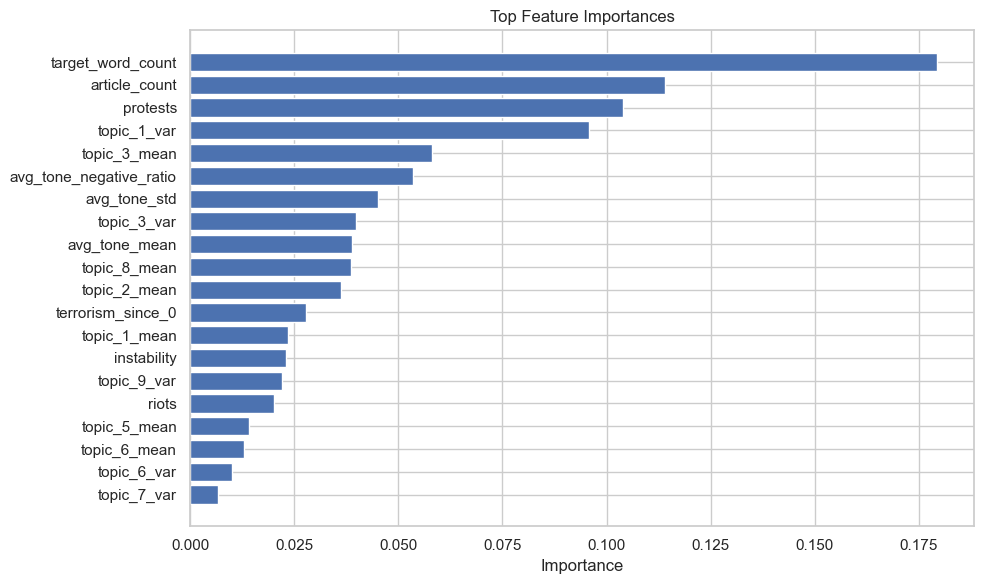

In [164]:
# Train a quick Random Forest on full dataset to get feature importances
feature_model = RandomForestClassifier(
    max_depth=10, 
    max_features=0.2, 
    min_samples_leaf=100, 
    n_jobs=-1, 
    random_state=42
)

# Train only on rows without NaNs in target
mask = merged_gtd_acled_gdelt['inc_anyterrorism_th0_h3'].notna()
feature_model.fit(X[mask], merged_gtd_acled_gdelt.loc[mask, 'inc_anyterrorism_th0_h3'])

# Get importances
importances = feature_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_n = 20
print(f"Top {top_n} important features:\n", feature_importance_df.head(top_n))

plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df.head(top_n)['feature'][::-1],
    feature_importance_df.head(top_n)['importance'][::-1]
)
plt.xlabel("Importance")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()


In [165]:
top_features = feature_importance_df.head(20)['feature'].tolist()
X_top = X[top_features]

In [171]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Define parameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', 0.2, 0.5],
    'class_weight': [None, 'balanced']
}

# Use f1 for imbalanced classes (or use 'roc_auc' for general performance)
scorer = make_scorer(f1_score, average='binary', zero_division=0)

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # Number of random combinations to try
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit to a subset of your data (recommended for tuning)
mask = merged_gtd_acled_gdelt['inc_anyterrorism_th0_h3'].notna()
random_search.fit(X_top[mask], merged_gtd_acled_gdelt.loc[mask, 'inc_anyterrorism_th0_h3'])

# Best model
best_rf = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': 0.2, 'max_depth': 15, 'class_weight': 'balanced'}


In [180]:
#Set key PanelSplit parameters
n_splits = 14
test_size = 1
horizon = 3
gap = horizon - 1

ps = PanelSplit(
    periods = merged_gtd_acled_gdelt.index.get_level_values('period'),
    n_splits=n_splits,
    test_size=test_size,
    gap = gap
)

inc_final_preds = ps.gen_test_labels(merged_gtd_acled_gdelt)

#before running predictions, check that the indices of the target and features are the same
assert merged_gtd_acled_gdelt.index.equals(X.index), "Indices of target and features do not match. Please check your data."

inc_preds, fitted_estimators_inc = cross_val_fit_predict(
    estimator=best_rf,
    X=X_top,
    y=merged_gtd_acled_gdelt['inc_anyterrorism_th0_h3'],
    cv=ps,
    method='predict_proba',
    drop_na_in_y=True
)

#save predictions
inc_final_preds['inc_preds'] = inc_preds[:, 1]

inc_final_preds.to_csv('incidence_predictions.csv')
with open('fitted_estimators_inc.pkl', 'wb') as f:
    pickle.dump(fitted_estimators_inc, f)

y_true = merged_gtd_acled_gdelt.loc[inc_final_preds.index, 'inc_anyterrorism_th0_h3']

y_pred_proba = inc_final_preds['inc_preds']
y_pred = (y_pred_proba >= 0.5).astype(int)

# Create a mask to filter out NaN values
mask = ~y_true.isna()
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]
y_pred_proba_filtered = y_pred_proba[mask]

accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
precision = precision_score(y_true_filtered, y_pred_filtered, zero_division=0)
recall = recall_score(y_true_filtered, y_pred_filtered, zero_division=0)
f1 = f1_score(y_true_filtered, y_pred_filtered, zero_division=0)
roc_auc = roc_auc_score(y_true_filtered, y_pred_proba_filtered)
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)

print("Classification Report for RF:")
print(classification_report(y_true_filtered, y_pred_filtered, zero_division=0))

print("Confusion Matrix:")
print(conf_matrix)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

Classification Report for RF:
              precision    recall  f1-score   support

         0.0       0.74      0.42      0.54       238
         1.0       0.42      0.74      0.54       136

    accuracy                           0.54       374
   macro avg       0.58      0.58      0.54       374
weighted avg       0.62      0.54      0.54       374

Confusion Matrix:
[[101 137]
 [ 36 100]]
Accuracy: 0.537
Precision: 0.422
Recall: 0.735
F1 Score: 0.536
ROC AUC: 0.619


## Getting predictions with a HistGradientBoostingClassifier

In [ ]:
# Set key PanelSplit parameters
n_splits = 15
test_size = 1
horizon = 3
gap = horizon - 1

ps = PanelSplit(
    periods = merged_gtd_acled_gdelt.index.get_level_values('period'),
    n_splits=n_splits,
    test_size=test_size,
    gap=gap
)

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

inc_final_preds = ps.gen_test_labels(merged_gtd_acled_gdelt)

# Ensure indices match
assert merged_gtd_acled_gdelt.index.equals(X_scaled.index), "Indices of target and features do not match. Please check your data."

hgb_model = HistGradientBoostingClassifier(
    max_iter=100,
    learning_rate=0.1,
    max_depth=6,
    l2_regularization=0.1,
    early_stopping=True,
    random_state=42
)

inc_preds, fitted_estimators_inc = cross_val_fit_predict(
    estimator=hgb_model,
    X=X_top,
    y=merged_gtd_acled_gdelt['inc_anyterrorism_th0_h3'],
    cv=ps,
    method='predict_proba',
    drop_na_in_y=True
)

inc_final_preds['inc_preds_hgb'] = inc_preds[:, 1]


y_true = merged_gtd_acled_gdelt.loc[inc_final_preds.index, 'inc_anyterrorism_th0_h3']

y_pred_proba = inc_final_preds['inc_preds_hgb']
y_pred = (y_pred_proba >= 0.6).astype(int)

mask = ~y_true.isna()

y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]
y_pred_proba_filtered = y_pred_proba[mask]

accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
precision = precision_score(y_true_filtered, y_pred_filtered, zero_division=0)
recall = recall_score(y_true_filtered, y_pred_filtered, zero_division=0)
f1 = f1_score(y_true_filtered, y_pred_filtered, zero_division=0)
roc_auc = roc_auc_score(y_true_filtered, y_pred_proba_filtered)
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)

print("Classification Report for HGB:")
print(classification_report(y_true_filtered, y_pred_filtered, zero_division=0))

print("Confusion Matrix:")
print(conf_matrix)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")


Incidence prediction done.


## Getting predictions with LogisticRegression

In [147]:
# Set key PanelSplit parameters
n_splits = 15
test_size = 1
horizon = 3
gap = horizon - 1

ps = PanelSplit(
    periods=merged_gtd_acled_gdelt.index.get_level_values('period'),
    n_splits=n_splits,
    test_size=test_size,
    gap=gap
)

inc_final_preds = ps.gen_test_labels(merged_gtd_acled_gdelt)

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

# Ensure indices match
assert merged_gtd_acled_gdelt.index.equals(X_scaled.index), "Indices of target and features do not match. Please check your data."

# Logistic Regression model
logreg_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

inc_preds, fitted_estimators_inc = cross_val_fit_predict(
    estimator=logreg_model,
    X=X_scaled,
    y=merged_gtd_acled_gdelt['inc_anyterrorism_th0_h3'],
    cv=ps,
    method='predict_proba',
    drop_na_in_y=True
)

# Save predictions
inc_final_preds['inc_preds_lr'] = inc_preds[:, 1]

y_true = merged_gtd_acled_gdelt.loc[inc_final_preds.index, 'inc_anyterrorism_th0_h3']

y_pred_proba = inc_final_preds['inc_preds_lr']
y_pred = (y_pred_proba >= 0.6).astype(int)

mask = ~y_true.isna()

y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]
y_pred_proba_filtered = y_pred_proba[mask]

accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
precision = precision_score(y_true_filtered, y_pred_filtered, zero_division=0)
recall = recall_score(y_true_filtered, y_pred_filtered, zero_division=0)
f1 = f1_score(y_true_filtered, y_pred_filtered, zero_division=0)
roc_auc = roc_auc_score(y_true_filtered, y_pred_proba_filtered)
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)

print("Classification Report for LR:")
print(classification_report(y_true_filtered, y_pred_filtered, zero_division=0))

print("Confusion Matrix:")
print(conf_matrix)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

Classification Report for LR:
              precision    recall  f1-score   support

         0.0       0.63      0.48      0.54       247
         1.0       0.42      0.57      0.48       161

    accuracy                           0.51       408
   macro avg       0.52      0.52      0.51       408
weighted avg       0.55      0.51      0.52       408

Confusion Matrix:
[[118 129]
 [ 69  92]]
Accuracy: 0.515
Precision: 0.416
Recall: 0.571
F1 Score: 0.482
ROC AUC: 0.504


## Evaluating the predictions

In [181]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import average_precision_score
from sklearn.metrics import (
  auc,
  average_precision_score,
  precision_recall_curve,
  roc_curve,
)

target_col='inc_anyterrorism_th0_h3'
prediction_col='inc_preds'

predictions=pd.read_csv("incidence_predictions.csv".format(target_col))

In [175]:
predictions

,state,period,terrorism,anyterrorism_th0,inc_anyterrorism_th0_h3,ons_anyterrorism_th0_h3,terrorism_basic_lag1,terrorism_basic_lag3,terrorism_rolling_sum1,terrorism_rolling_sum3,...,topic_1_var,topic_2_var,topic_3_var,topic_4_var,topic_5_var,topic_6_var,topic_7_var,topic_8_var,topic_9_var,inc_preds
0,AL,202005,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.022811,0.036916,0.050293,0.015009,0.024090,0.017220,0.000014,0.054720,0.021058,0.497258
1,AL,202006,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.019660,0.029083,0.050032,0.011855,0.021120,0.026335,0.002686,0.052732,0.019295,0.624597
2,AL,202007,1.0,1,0.0,NaN,0.0,0.0,1.0,1.0,...,0.016448,0.024034,0.064276,0.015636,0.017917,0.031910,0.000003,0.037956,0.024393,0.699665
3,AL,202008,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.021498,0.040051,0.035386,0.014927,0.022319,0.024771,0.000007,0.061607,0.029983,0.483489
4,AL,202009,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.018607,0.032429,0.034804,0.012797,0.022231,0.026560,0.002551,0.059589,0.044886,0.475056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,WI,202102,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.020743,0.037467,0.042312,0.012513,0.020037,0.036474,0.001447,0.050884,0.021085,0.254629
472,WI,202103,1.0,1,0.0,NaN,0.0,0.0,1.0,1.0,...,0.016609,0.039921,0.025143,0.011685,0.020063,0.028184,0.003644,0.055894,0.025424,0.152938
473,WI,202104,0.0,0,NaN,NaN,1.0,0.0,0.0,1.0,...,0.015244,0.037502,0.040827,0.006687,0.019661,0.024668,0.001834,0.067756,0.026888,0.185609
474,WI,202105,0.0,0,NaN,NaN,0.0,0.0,0.0,1.0,...,0.019146,0.034942,0.034912,0.010779,0.017436,0.030310,0.000005,0.059010,0.028510,0.178104


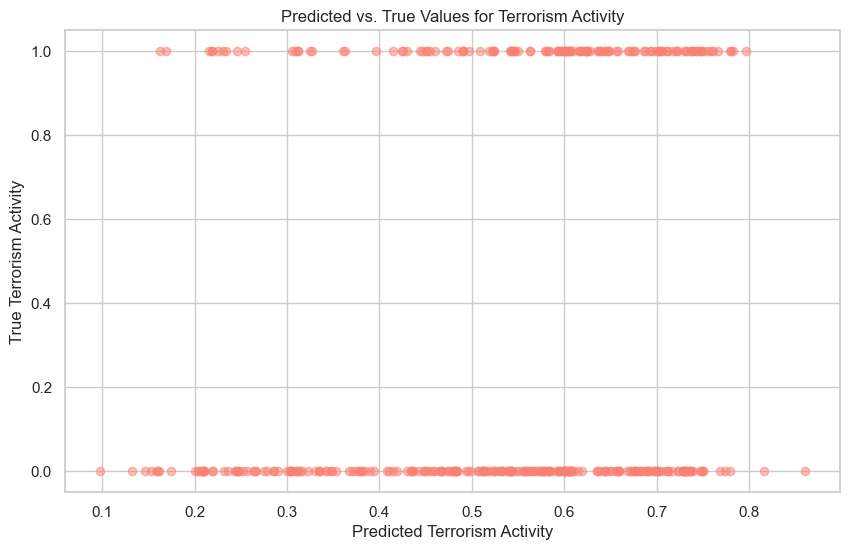

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions[prediction_col], predictions[target_col], color='salmon', alpha=0.5)
plt.title('Predicted vs. True Values for Terrorism Activity')
plt.xlabel('Predicted Terrorism Activity')
plt.ylabel('True Terrorism Activity')
plt.grid(True)
plt.show()

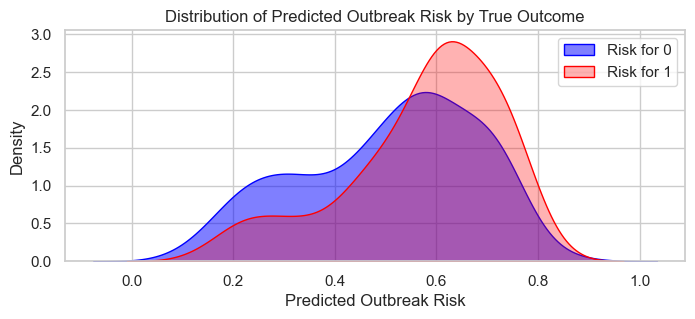

In [182]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 3))

sns.kdeplot(predictions.loc[predictions[target_col] == 0, prediction_col], color="blue", fill=True, alpha=0.5, label='Risk for 0')

sns.kdeplot(predictions.loc[predictions[target_col] == 1, prediction_col], color="red", fill=True, alpha=0.3, label='Risk for 1')

plt.title('Distribution of Predicted Outbreak Risk by True Outcome')
plt.xlabel('Predicted Outbreak Risk')
plt.ylabel('Density')

plt.legend()

In [183]:
def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y : vector of observed class labels
        yhat : vector of predicted probabilities
        fname: file path to directory to save plot
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''

    pdata = pdata.dropna(subset=[pdata.columns[0], pdata.columns[1]])
    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]

    evals = events.index.values


    plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted risk')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])


    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'Onsets', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)

    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted risk', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    plt.savefig(fname)
    plt.show()
    plt.close()

In [184]:
def draw_precision_curve(y, x, name):
    valid_indices = y.notnull() & x.notnull()
    y, x = y[valid_indices], x[valid_indices]

    precision, recall, thresholds = precision_recall_curve(y, x)
    avprec = average_precision_score(y, x)

    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, lw=3, label='Av.Precision = %0.2f' % avprec)

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks([i / 5 for i in range(6)])
    plt.yticks([i / 5 for i in range(6)])
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision/Recall Curve')
    plt.legend(loc="lower left")
    plt.show()


def draw_roc_curve(y, x, name):
    valid_indices = y.notnull() & x.notnull()
    y, x = y[valid_indices], x[valid_indices]

    fpr, tpr, thresholds = roc_curve(y, x)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=3, label='AUC = %0.2f' % roc_auc)

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks([i / 5 for i in range(6)])
    plt.yticks([i / 5 for i in range(6)])
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

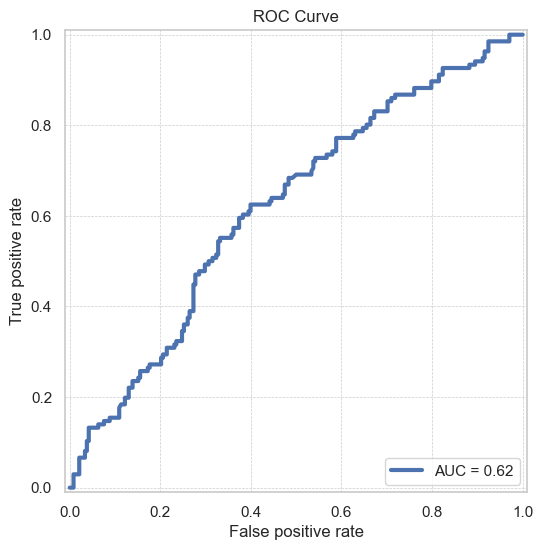

In [186]:
draw_roc_curve(predictions[target_col],predictions[prediction_col],'roc_inc_all'+target_col)

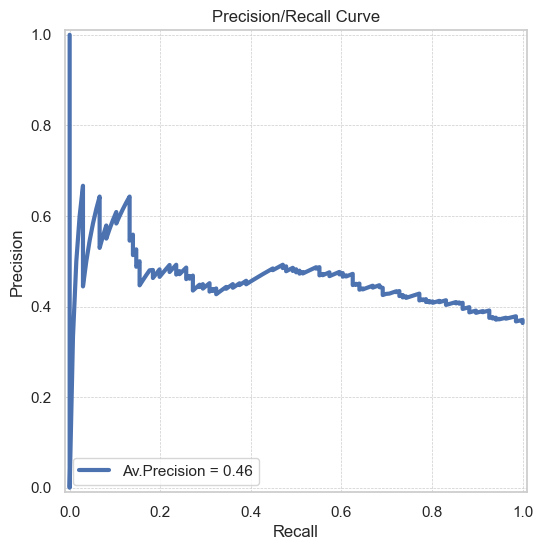

In [185]:
draw_precision_curve(predictions[target_col],predictions[prediction_col],'prec_inc_all'+target_col)